This notebook shows how to write the output of CHASM to a CORSIKA IACT eventio format file. First let's make a CHASM simulation.

In [1]:
%matplotlib widget
import numpy as np
import CHASM as ch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import eventio
from scipy.stats import iqr

THETA = np.deg2rad(30.)
PHI = np.deg2rad(45.)
OBS = 0.
grid_side = np.linspace(-1000,1000,10)
TELX, TELY = np.meshgrid(grid_side,grid_side)
TELZ = np.full_like(TELX, OBS)
TEL_VECTORS = np.vstack((TELX.flatten(), TELY.flatten(), TELZ.flatten())).T

sim = ch.ShowerSimulation()
sim.add(ch.DownwardAxis(THETA, PHI, OBS))
sim.add(ch.SphericalCounters(TEL_VECTORS,1))
sim.add(ch.GHShower(600,1.e6,0.,70))
sim.add(ch.Yield(300,450,1))

Now let's run the simulation to create a ShowerSignal object.

In [2]:
sig = sim.run()

We can also run with the shower mesh option, this will take a bit longer.

In [3]:
sig_mesh = sim.run(mesh=True)

Now we can make IACT files from these signals.

In [4]:
ei_filename = 'iact.dat'
ei_filename_mesh = 'iact_mesh.dat'

ch.write_ei_file(sig, ei_filename)
ch.write_ei_file(sig_mesh, ei_filename_mesh)

Now let's read in these files with the eventio reader.

In [5]:
ei = eventio.IACTFile(ei_filename)
ei_mesh = eventio.IACTFile(ei_filename_mesh)

Now let's look at the approximate coordinates of the bunch origins (minus the offset between the surface of the spherical IACT and its center. We use a built in CHASM function to do this.

In [6]:
x,y,z,p = ch.bunch_origins(ei)
xm,ym,zm,pm = ch.bunch_origins(ei_mesh)

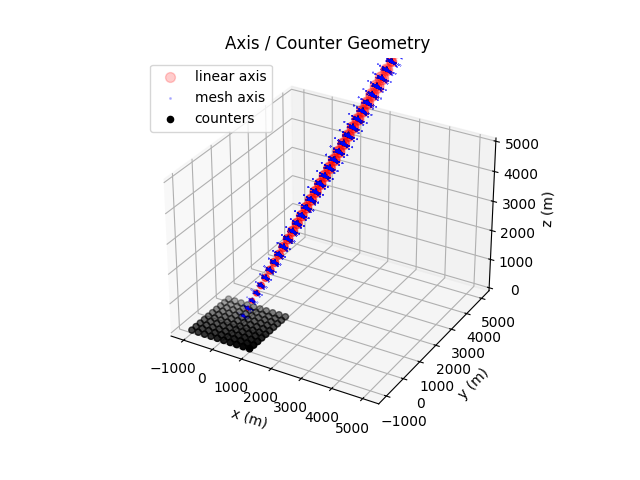

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x, y ,z ,c='r', s=100*p/p.max(), alpha=0.2, label='linear axis')
ax.scatter(xm, ym ,zm ,c='b', s=100*pm/p.max(), alpha=0.2, label='mesh axis')
ax.scatter(TEL_VECTORS[:,0],TEL_VECTORS[:,1],TEL_VECTORS[:,2], c='k', label = 'counters')
ax.set_zlim(0,5000)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
plt.title('Axis / Counter Geometry')
plt.legend();

We can also plot the photons arriving at one counter by accessing the bunches.

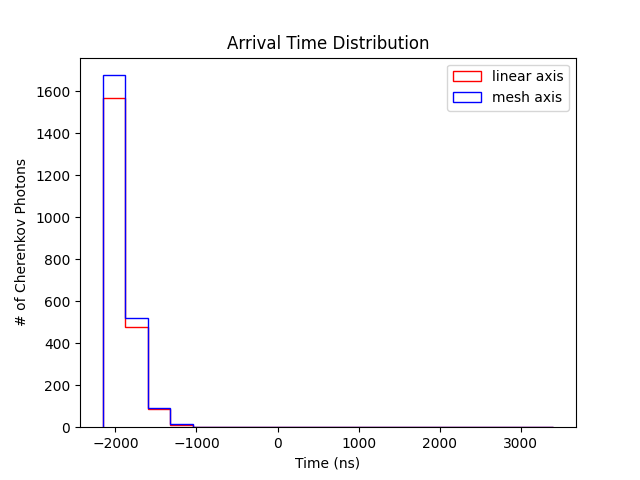

In [8]:
event = next(iter(ei))
event_mesh = next(iter(ei_mesh))
ic = 99

bins = event.photon_bunches[ic]['time'].min() , event.photon_bunches[ic]['time'].max()
nbins = 20
plt.figure()
plt.hist(event.photon_bunches[ic]['time'],nbins,bins,weights = event.photon_bunches[ic]['photons'],histtype='step', label='linear axis', color = 'r')
plt.hist(event_mesh.photon_bunches[ic]['time'],nbins,bins,weights = event_mesh.photon_bunches[ic]['photons'],histtype='step', label='mesh axis', color = 'b')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('# of Cherenkov Photons')
plt.title('Arrival Time Distribution');

CORSIKA IACT records the coordinates of the where each photon bunch strikes the observation level relative to the center of the shadow of the detector. To reproduce this accurately, I assign a uniformly distributed random polar coordinate within a circle with the same radius as the spherical detector to photons from each sampled axis point. Then, for each of the sampled locations, I calculate the transformation of the circle to the elliptical shadow of the detector as produced by paralell beams from the sampled location. Applying this transformation to the polar points assigned to photons from each sampled location yields the x and y coordinates relative to the center of the shadow.

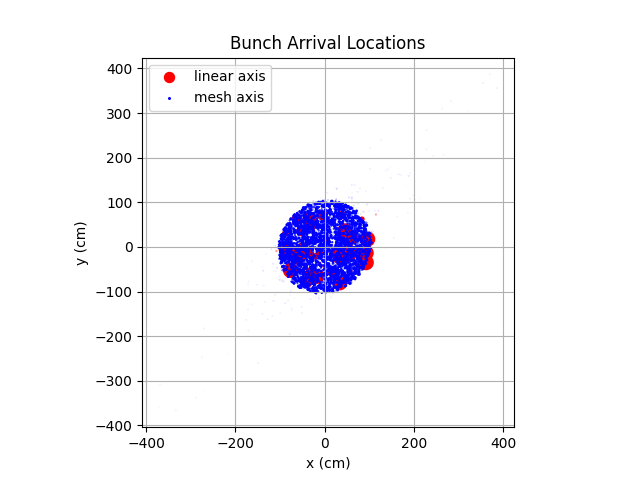

In [9]:
plt.figure()
plt.grid()
plt.scatter(event.photon_bunches[ic]['x'],event.photon_bunches[ic]['y'],s = event.photon_bunches[ic]['photons'], label='linear axis', c='r')
plt.scatter(event_mesh.photon_bunches[ic]['x'],event_mesh.photon_bunches[ic]['y'], s = event_mesh.photon_bunches[ic]['photons'], label='mesh axis', c='b')
plt.gca().set_aspect('equal')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.title('Bunch Arrival Locations');

array([-111.11111111, -111.11111111,    0.        ])

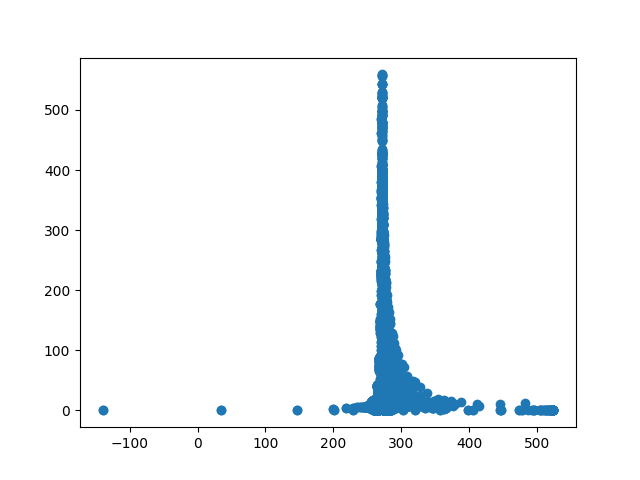

In [10]:
plt.figure()
plt.scatter(sig_mesh.times[44,:],sig_mesh.photons[44,0,:])
sig_mesh.photons.shape
TEL_VECTORS[44]

